### Detction de Cadastre

Les todo : 
- matching du cadastre sur sattelite ( gerer les translation, le zoom et la rotation )
- Detection de piscine sur l'image 
- comparer avec le cadastre 
- faire un flux API 

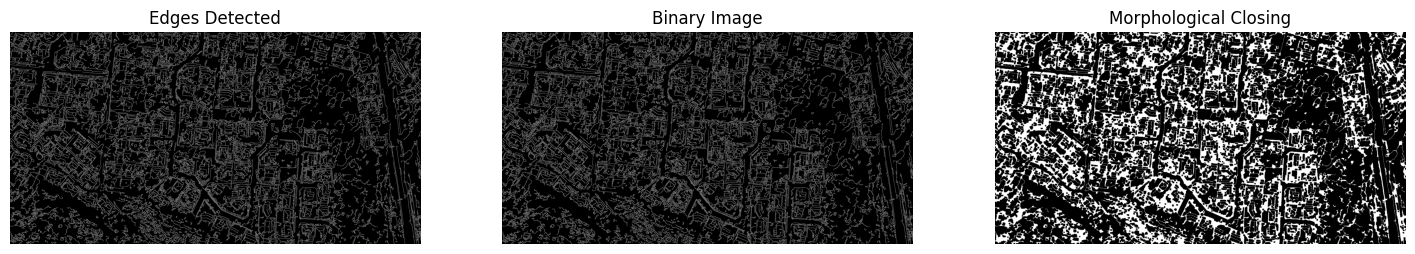

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
file_path = 'Sattelite test.png'  # Replace with your image path
image = cv2.imread(file_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Edge detection using Canny algorithm
edges = cv2.Canny(blurred, 50, 150)

# Apply binary threshold to get a binary image
_, binary_image = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)

# Define a kernel for the morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))

# Morphological operations to close gaps in the road edges
closed = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

# Display the processed images
plt.figure(figsize=(18, 9))

plt.subplot(1, 3, 1)
plt.imshow(edges, cmap='gray')
plt.title('Edges Detected')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(closed, cmap='gray')
plt.title('Morphological Closing')
plt.axis('off')

plt.show()


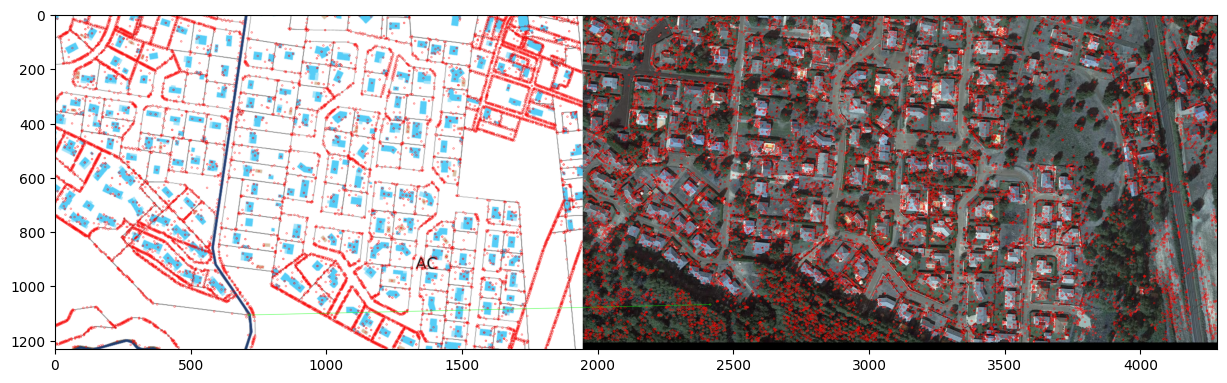

Not enough matches are found - 1/4


In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Paths to the input images
satellite_image_path = 'Sattelite test.png'
cadastre_image_path = 'Cadastre test.png'

# Load the images
satellite_image = cv2.imread(satellite_image_path)
cadastre_image = cv2.imread(cadastre_image_path)

# Convert images to grayscale
satellite_gray = cv2.cvtColor(satellite_image, cv2.COLOR_BGR2GRAY)
cadastre_gray = cv2.cvtColor(cadastre_image, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints_satellite, descriptors_satellite = sift.detectAndCompute(satellite_gray, None)
keypoints_cadastre, descriptors_cadastre = sift.detectAndCompute(cadastre_gray, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(descriptors_cadastre, descriptors_satellite, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# Ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

# Draw the matches
img3 = cv2.drawMatchesKnn(cadastre_image, keypoints_cadastre, satellite_image, keypoints_satellite, matches, None, **draw_params)

plt.figure(figsize=(15, 7))
plt.imshow(img3)
plt.show()

# Proceed to compute homography and warp image if we have enough good matches
good_matches = [m for m, mask in zip(matches, matchesMask) if mask[0]]
if len(good_matches) > 4:  # Minimum number of matches to compute homography
    # Extract location of good matches
    points_cadastre = np.float32([keypoints_cadastre[m[0].queryIdx].pt for m in good_matches])
    points_satellite = np.float32([keypoints_satellite[m[0].trainIdx].pt for m in good_matches])

    # Find homography matrix
    H, status = cv2.findHomography(points_cadastre, points_satellite, cv2.RANSAC,5.0)

    # Warp cadastre image to fit satellite image
    height, width, channels = satellite_image.shape
    warped_cadastre = cv2.warpPerspective(cadastre_image, H, (width, height))

    plt.figure(figsize=(15, 7))
    plt.imshow(cv2.cvtColor(warped_cadastre, cv2.COLOR_BGR2RGB))
    plt.title("Warped Cadastre Image")
    plt.axis('off')
    plt.show()
else:
    print("Not enough matches are found - {}/{}".format(len(good_matches), 4))


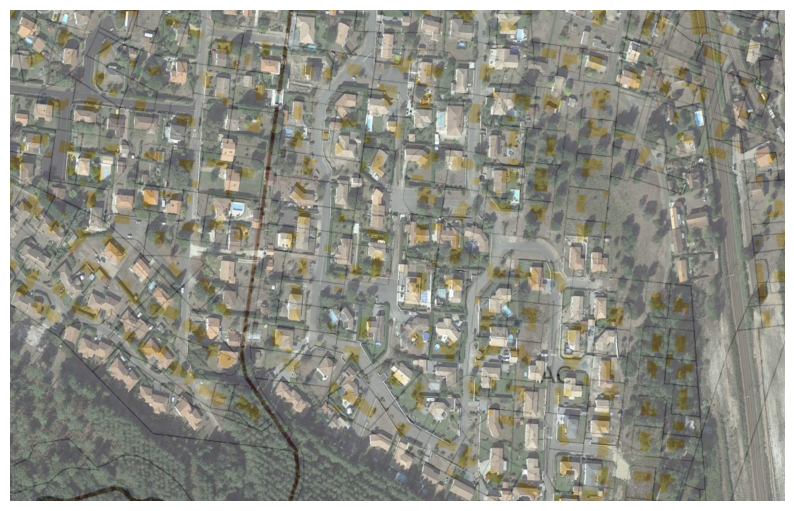

'/mnt/data/overlay_image.png'

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
cadastre_img = cv2.imread('Cadastre test.png', cv2.IMREAD_UNCHANGED)
satellite_img = cv2.imread('Sattelite test.png', cv2.IMREAD_UNCHANGED)

# We need to ensure that the images are in the same scale and orientation
# Normally, this would involve feature matching and homography finding
# However, without known corresponding points or features, this is not feasible
# Instead, we will overlay the images with transparency for visual comparison
# This is a simple overlay and does not involve any spatial transformation

# Resize images to be the same size
# We will resize satellite_img to match cadastre_img size for simplicity
satellite_img_resized = cv2.resize(satellite_img, (cadastre_img.shape[1], cadastre_img.shape[0]))

# Create an overlay image
alpha = 0.3 # Define the transparency for the overlay
overlay_img = cv2.addWeighted(cadastre_img, alpha, satellite_img_resized, 1 - alpha, 0)

# Save the result
overlay_path = '/mnt/data/overlay_image.png'
cv2.imwrite(overlay_path, overlay_img)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide the axis
plt.show()

overlay_path


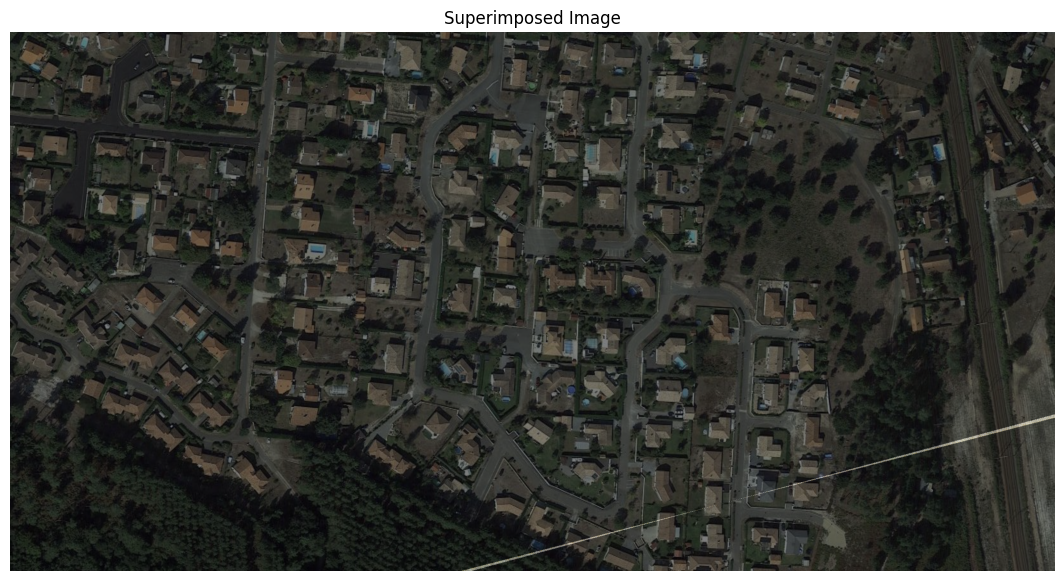

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


# Load the images
satellite_image = cv2.imread(satellite_image_path)
cadastre_image = cv2.imread(cadastre_image_path)

# Convert images to grayscale for feature detection
satellite_gray = cv2.cvtColor(satellite_image, cv2.COLOR_BGR2GRAY)
cadastre_gray = cv2.cvtColor(cadastre_image, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints_satellite, descriptors_satellite = sift.detectAndCompute(satellite_gray, None)
keypoints_cadastre, descriptors_cadastre = sift.detectAndCompute(cadastre_gray, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(descriptors_cadastre, descriptors_satellite, k=2)

# Filter out good matches
good_matches = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good_matches.append(m)

if len(good_matches) > 4:
    # Extract location of good matches
    points_cadastre = np.float32([keypoints_cadastre[m.queryIdx].pt for m in good_matches])
    points_satellite = np.float32([keypoints_satellite[m.trainIdx].pt for m in good_matches])

    # Find homography matrix
    H, status = cv2.findHomography(points_cadastre, points_satellite, cv2.RANSAC,5.0)

    # Warp cadastre image to fit satellite image
    height, width, channels = satellite_image.shape
    warped_cadastre = cv2.warpPerspective(cadastre_image, H, (width, height))

    # Superpose the images
    alpha = 0.5  # Transparency factor.
    # The cv2.addWeighted function calculates the weighted sum of two arrays
    superimposed_img = cv2.addWeighted(warped_cadastre, alpha, satellite_image, 1 - alpha, 0)

    plt.figure(figsize=(15, 7))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Superimposed Image")
    plt.axis('off')
    plt.show()
else:
    print("Not enough matches are found - {}/{}".format(len(good_matches), 4))


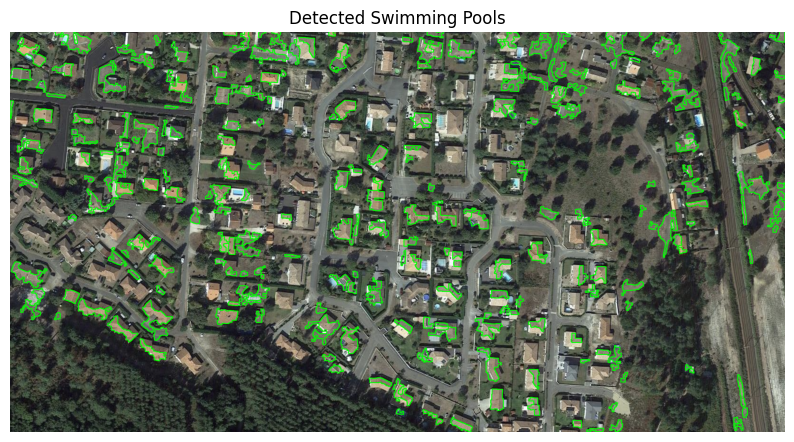

In [45]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the satellite image

image = cv2.imread(satellite_image_path)

# Convert the image to the HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the range for blue color typical for swimming pools
# These ranges can vary, might need tuning for the specific image
lower_blue = np.array([100, 50, 50])
upper_blue = np.array([140, 255, 255])

# Create a mask with the specified blue range
mask = cv2.inRange(image, lower_blue, upper_blue)

# Use morphological operations to clean up the mask
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel)

# Find contours in the cleaned mask
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on area and shape
pool_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 200 and area < 5000:  # Area threshold for pools, may need tuning
        perimeter = cv2.arcLength(contour, True)
        approximation = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        if len(approximation) >= 4:
            pool_contours.append(contour)

# Draw the contours on the image
image_with_pools = image.copy()
cv2.drawContours(image_with_pools, pool_contours, -1, (0, 255, 0), 2)

# Show the result
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_with_pools, cv2.COLOR_BGR2RGB))
plt.title('Detected Swimming Pools')
plt.axis('off')
plt.show()


In [23]:
import folium
import json

# Load the GeoJSON data from a file
with open('cadastre-40160-communes.json', 'r') as file:
    geojson_data = json.load(file)

# Use Shapely to calculate the center of the bounding box
multi_polygon = shape(geojson_data['features'][0]['geometry'])
bounds = multi_polygon.bounds  # Returns (minx, miny, maxx, maxy)
center_x = (bounds[0] + bounds[2]) / 2
center_y = (bounds[1] + bounds[3]) / 2
center_point = (center_x, center_y)

center_point = (center_point[1],center_point[0])

In [55]:
import folium
import json
from shapely.geometry import shape

import branca

# Create a white image of 4 pixels, and embed it in a url.
white_tile = branca.utilities.image_to_url([[1, 1], [1, 1]])

# Load the GeoJSON data from a file
with open('cadastre-34130-parcelles.json', 'r') as file:
    geojson_data = json.load(file)

center_point = (43.523563486592614, 3.193477578841215)
# Create a folium map object
m = folium.Map(location=center_point, zoom_start=50, tiles=white_tile,attr="white tile")

# Add the GeoJSON data to the map
folium.GeoJson(geojson_data).add_to(m)

m

In [50]:
from ipyleaflet import Map, basemaps, basemap_to_tiles


center_point = (43.523563486592614, 3.193477578841215)

def create_satellite_view(latitude, longitude, zoom=18):
    satellite_layer = basemap_to_tiles(basemaps.Esri.WorldImagery)

    m = Map(center=(latitude, longitude), zoom=zoom)
    m.add_layer(satellite_layer)


    return m


latitude = center_point[0]
longitude = center_point[1]

# Display the map with satellite view
create_satellite_view(latitude, longitude)


Map(center=[43.523563486592614, 3.193477578841215], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [54]:
from ipyleaflet import Map, GeoJSON
import json

# Load the GeoJSON data from a file
with open('cadastre-34130-parcelles.json', 'r') as file:
    geojson_data = json.load(file)

center_point = (43.523563486592614, 3.193477578841215)
satellite_layer = basemap_to_tiles(basemaps.Esri.WorldImagery)
# Create an ipyleaflet map object
m = Map(center=center_point, zoom=18)
m.add_layer(satellite_layer)
# Add the GeoJSON data to the map
geo_json_layer = GeoJSON(data=geojson_data)
m.add_layer(geo_json_layer)

# Display the map in the Jupyter Notebook
m

Map(center=[43.523563486592614, 3.193477578841215], controls=(ZoomControl(options=['position', 'zoom_in_text',…

- From coordonate --> commune 
- image avec et sans cadastre 
- detection piscine 